In [40]:
import numpy as np
from scipy.io import loadmat
from matplotlib import pyplot as plt
import time

In [41]:
rootfolder = '..'

Useful function for plot the 2D DCT dictionary

In [42]:
def get_dictionary_img(D):
    M, N = D.shape
    p = int(round(np.sqrt(M)))
    nnn = int(np.ceil(np.sqrt(N)))
    bound = 2
    img = np.ones((nnn*p+bound*(nnn-1), nnn*p+bound*(nnn-1)))
    for i in range(N):
        m = np.mod(i, nnn)
        n = int((i-m)/nnn)
        m = m * p + bound * m
        n = n * p + bound * n
        atom = D[:, i].reshape((p, p))
        if atom.min() < atom.max():
            atom = (atom - atom.min()) / (atom.max() - atom.min())
        img[m: m + p, n: n + p] = atom

    return img

Define a function that implements the OMP

In [43]:
def OMP(s, D, L, tau):
    D = D / np.linalg.norm(D, axis=0, keepdims=True)
    M, N = D.shape
    r = s
    x = np.zeros(N)
    omega = []
    while np.linalg.norm(r) > tau:
        j = np.argmax(np.abs(np.dot(D.T, r)))
        omega.append(j)
        x_omega = np.linalg.lstsq(D[:, omega], s, rcond=None)[0]
        x = np.zeros(N)
        x[omega] = x_omega
        r = s - np.dot(D, x)
    return x

Load the image and rescale it in $[0,1]$

In [44]:
img = plt.imread(f'{rootfolder}/data/Lena512.png')

imsz = img.shape

# patch size
p = 8

# number of elements in the patch
M = p ** 2


Corrupt the image with white gaussian noise

In [45]:
sigma_noise = 20/255
noisy_img = img + np.random.normal(0, sigma_noise, size=imsz)

Compute the psnr of the noisy input

In [46]:
def psnr(P, Q):
    return -10 * np.log10(np.mean((P - Q) ** 2))

In [47]:
psnr_noisy = psnr(noisy_img, img)
psnr_noisy

22.10936115615967

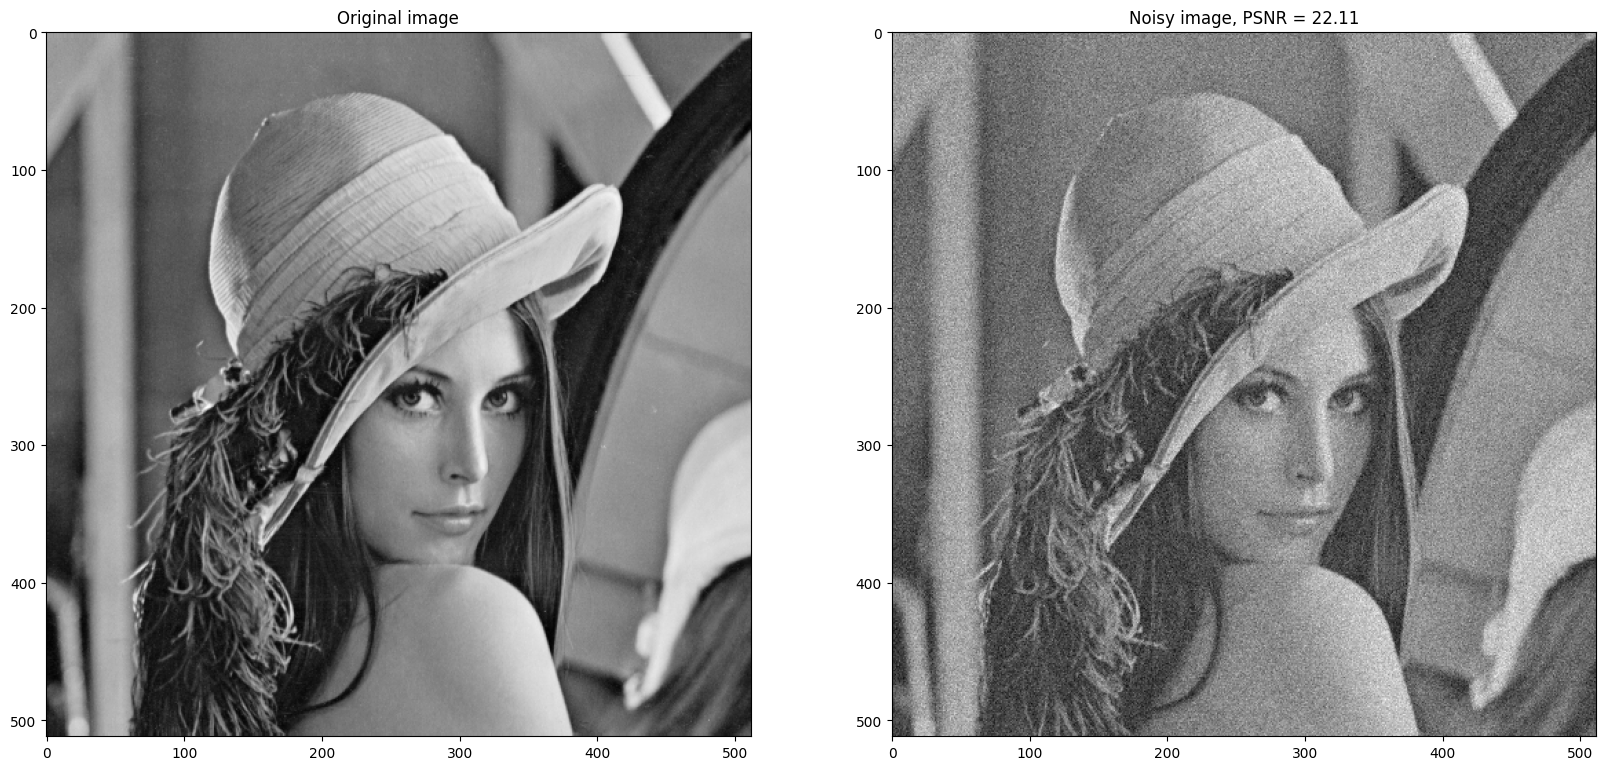

In [48]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original image')

ax[1].imshow(noisy_img, cmap='gray')
ax[1].set_title(f'Noisy image, PSNR = {psnr_noisy:.2f}');

Load and display the dictionary learned from patches

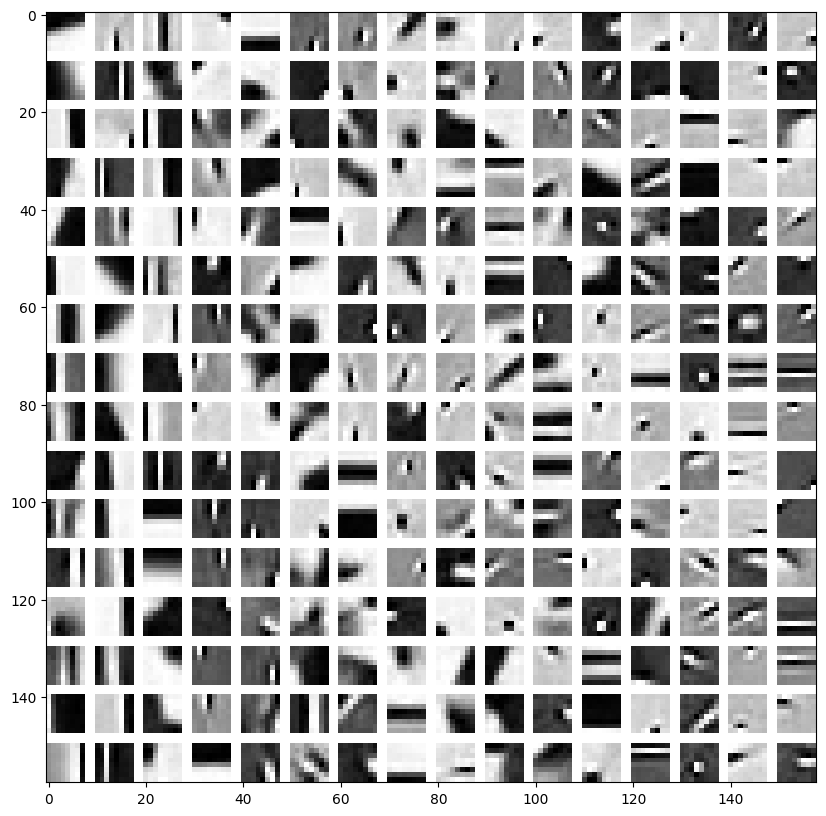

In [49]:
D = loadmat(f'{rootfolder}/data/dict_nat_img.mat')['D']

# display the dct basis
D_img = get_dictionary_img(D)
plt.figure(figsize=(10,10))
plt.imshow(D_img, cmap='gray');

Denoising
---------


In [50]:
# initialize the estimated image
img_hat = np.zeros(imsz)

# initialize the weight matrix
weights = np.zeros(imsz)

# set the threshold
tau = 1.15 * p * sigma_noise

# define the step (=p for non overlapping paches)
STEP = 4 # STEP = 1 might be very time consuming, start with larger STEP

Operate patchwise

In [51]:
for i in range(0, imsz[0] - p + 1, STEP):
    for j in range(0, imsz[1] - p + 1, STEP):
        # extrach the patch with the top left corner at pixel (ii, jj)
        s = noisy_img[i:i+p, j:j+p].flatten()

        # store and subtract the mean
        us = s.mean()
        s -= us

        # perform the sparse coding
        x = OMP(s, D, M, tau)

        # perform the reconstruction
        s_hat = np.dot(D, x)

        # add back the mean
        s_hat += us

        img_hat[i:i+p, j:j+p] += s_hat.reshape(p, p)
        weights[i:i+p, j:j+p] += 1

Normalize the estimated image with the computed weights

In [53]:
img_hat /= weights

Compute the psnr of the estimated image

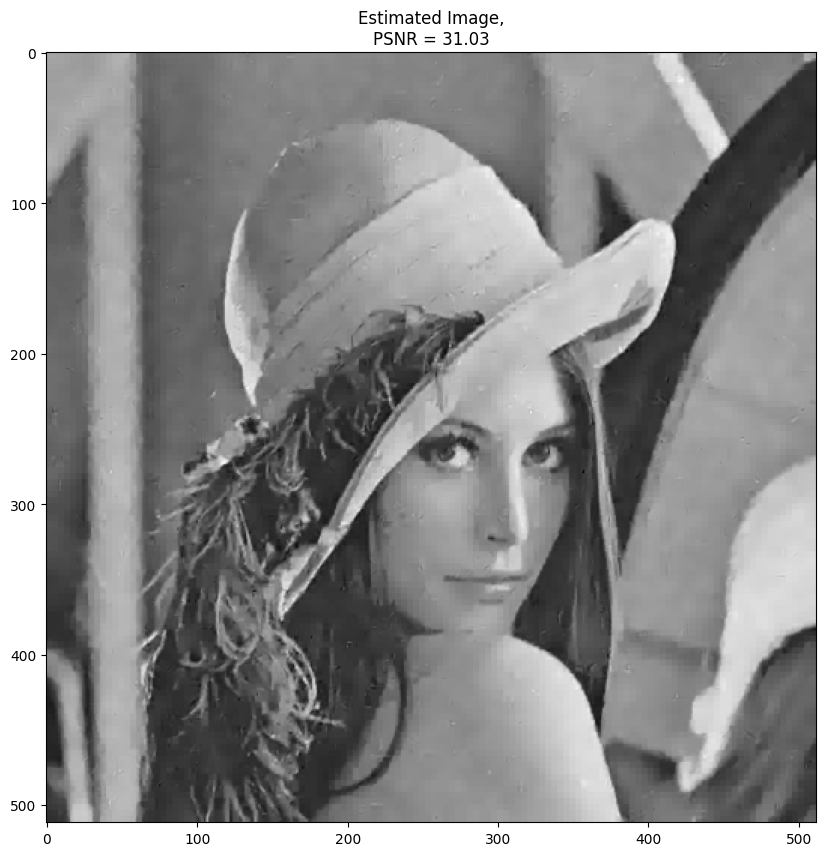

In [54]:
psnr_hat = psnr(img, img_hat)
plt.figure(figsize=(10,10))
plt.imshow(img_hat, cmap='gray')
plt.title(f'Estimated Image,\nPSNR = {psnr_hat:.2f}');